# CTA data analysis with Gammapy

## Caveat

* This notebook was prepared in a hurry, it is incomplete.
* The CTA first data challenge (1DC) data is still in preparation.
* Accessing background models doesn't work yet with Gammapy
* Several other small known issues with the data and Gammapy.
* Work in progress ... please excuse the mess!

## Introduction

The focus of this notebook is on demonstrating how to quickly perform a standard analysis of a given target in the sky. The gammapy functions and classes that we'll use won't be explained in detail. Please refer to the other gammapy tutorial notebooks, if you're interested.

At some point there should be a convenience class to make this kind of analysis easier, feedback on how this should be implemented is welcome!

## Setup

As usual, we'll start with some setup ...

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Check package versions, if something goes wrong here you won't be able to run the notebook

import numpy as np
import astropy
import regions
import sherpa
import uncertainties
import photutils

print('numpy:', np.__version__)
print('astropy:', astropy.__version__)
print('regions:', regions.__version__)
print('sherpa:', sherpa.__version__)
print('uncertainties:', uncertainties.__version__)
print('photutils:', photutils.__version__)

numpy: 1.12.0
astropy: 1.3
regions: 0.1
sherpa: 4.9.0
uncertainties: 2.4.8.1
photutils: 0.3.1


In [3]:
import numpy as np

import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from photutils.detection import find_peaks

from gammapy.data import DataStore
from gammapy.spectrum import (
    SpectrumExtraction,
    SpectrumFit,
    SpectrumResult,
    models,
    SpectrumEnergyGroupMaker,
    FluxPointEstimator,
)
from gammapy.image import SkyImage, IACTBasicImageEstimator
from gammapy.background import RingBackgroundEstimator
from gammapy.utils.energy import EnergyBounds
from gammapy.detect import TSImageEstimator

In [4]:
# Setup the logger
import logging
logging.basicConfig()
log = logging.getLogger('gammapy.spectrum')
log.setLevel(logging.ERROR)

## Load Data

First, we have to load the CTA data exported to fits format (the format is described in detail [here](https://gamma-astro-data-formats.readthedocs.io/en/latest/)).

In [5]:
DATA_DIR = '$GAMMAPY_EXTRA/test_datasets/cta_1dc'
# DATA_DIR = '/Users/deil/1dc/1dc.pre'

data_store = DataStore.from_dir(DATA_DIR)
data_store.info()


Data store summary info:
name: noname

HDU index table:
BASE_DIR: /home/hfm/adonath/Software/Repositories/gammapy-extra/test_datasets/cta_1dc
Rows: 10038
OBS_ID: 1 -- 1673
HDU_TYPE: ['aeff', 'bkg', 'edisp', 'events', 'gti', 'psf']
HDU_CLASS: ['aeff_2d', 'bkg_3d', 'edisp_2d', 'events', 'gti', 'psf_3gauss']

Observation table:
Number of observations: 1673


In [6]:
print(data_store.obs_table.colnames)
obs_colnames = ['OBS_ID', 'DATE_OBS', 'TIME_OBS', 'GLON_PNT', 'GLAT_PNT']
data_store.obs_table[::100][obs_colnames]

['OBS_ID', 'RA_PNT', 'DEC_PNT', 'GLON_PNT', 'GLAT_PNT', 'ZEN_PNT', 'ALT_PNT', 'AZ_PNT', 'ONTIME', 'LIVETIME', 'DEADC', 'TSTART', 'TSTOP', 'DATE_OBS', 'TIME_OBS', 'DATE_END', 'TIME_END', 'EVENTS_FILENAME', 'EVENT_COUNT', 'EVENT_TIME_MIN', 'EVENT_TIME_MAX', 'EVENT_ENERGY_MIN', 'EVENT_ENERGY_MAX']


OBS_ID,DATE_OBS,TIME_OBS,GLON_PNT,GLAT_PNT
int64,str10,str8,float64,float64
1,2021-01-01,11:58:51,359.500044973,-0.500037206629
101,2021-01-06,14:38:51,359.850020073,-0.416645559074
201,2021-01-11,17:18:51,0.0999876586067,-0.333402059745
301,2021-01-16,19:58:51,0.449997382071,-0.250026911671
401,2021-01-22,12:30:51,359.749994512,-0.0833922689931
501,2021-01-27,15:10:51,359.999985804,-1.94251867121e-05
601,2021-02-01,17:50:51,0.34998366634,0.0832847289392
701,2021-02-06,20:30:51,359.650013181,0.249974821922
801,2021-02-12,13:02:51,359.900010511,0.333332196219


## Select observations

In [7]:
# I've only copied EVENTS for these three obs for testing
# Trying to access any other will fail!
obs_id = [659, 1398, 1320]
observation_list = data_store.obs_list(obs_id)

In [8]:
data_store.obs_table.select_obs_id(obs_id)[obs_colnames]

OBS_ID,DATE_OBS,TIME_OBS,GLON_PNT,GLAT_PNT
int64,str10,str8,float64,float64
659,2021-02-04,18:22:51,0.100058295405,0.166660969419
1398,2021-03-15,17:18:51,5.13611286693e-05,2.00001672658
1320,2021-03-11,16:14:51,3.07691727701,-0.66667119626


In [9]:
obs = observation_list[0]

In [10]:
print(obs)

Info for OBS_ID = 659
- Start time: 665735040.00
- Pointing pos: RA 266.30 deg / Dec -28.76 deg
- Observation duration: 1800.0 s
- Dead-time fraction: 5.000 %



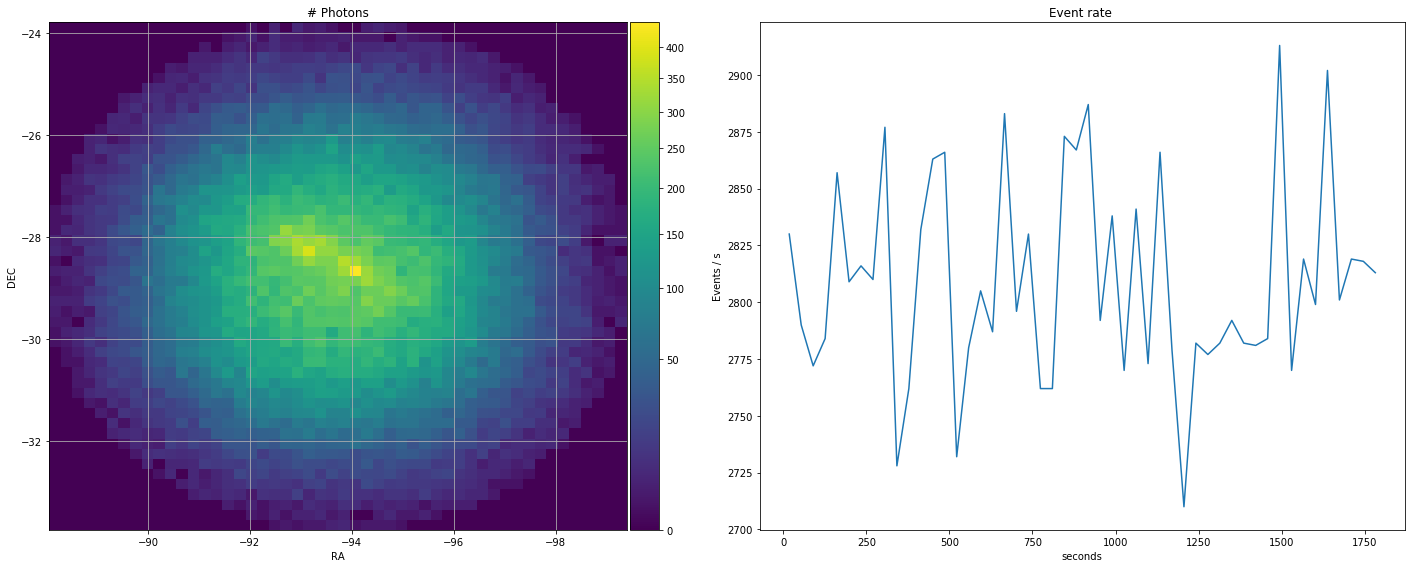

In [11]:
obs.events.peek()

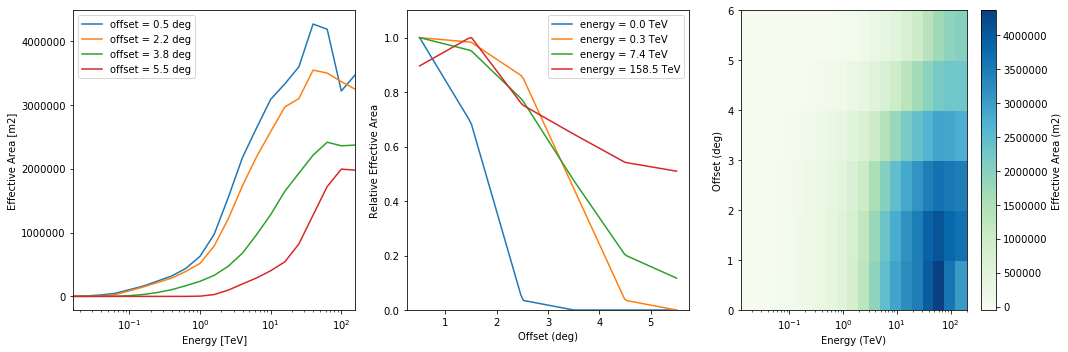

In [12]:
obs.aeff.peek()

/home/hfm/adonath/Software/Applications/anaconda3.5/lib/python3.5/site-packages/matplotlib/colors.py:1154: UserWarning: Power-law scaling on negative values is ill-defined, clamping to 0.
  warnings.warn("Power-law scaling on negative values is "
/home/hfm/adonath/Software/Applications/anaconda3.5/lib/python3.5/site-packages/astropy/units/quantity.py:951: RuntimeWarning: invalid value encountered in true_divide
  return super(Quantity, self).__truediv__(other)
/home/hfm/adonath/Software/Applications/anaconda3.5/lib/python3.5/site-packages/matplotlib/colors.py:1115: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)


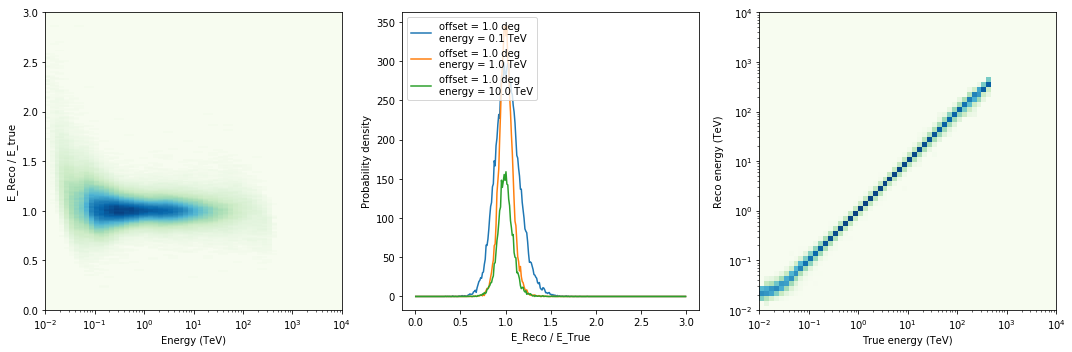

In [13]:
obs.edisp.peek()

/home/hfm/adonath/Software/Repositories/gammapy/gammapy/image/models/gauss.py:254: RuntimeWarning: invalid value encountered in true_divide
  self.norms /= self.integral
/home/hfm/adonath/Software/Applications/anaconda3.5/lib/python3.5/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


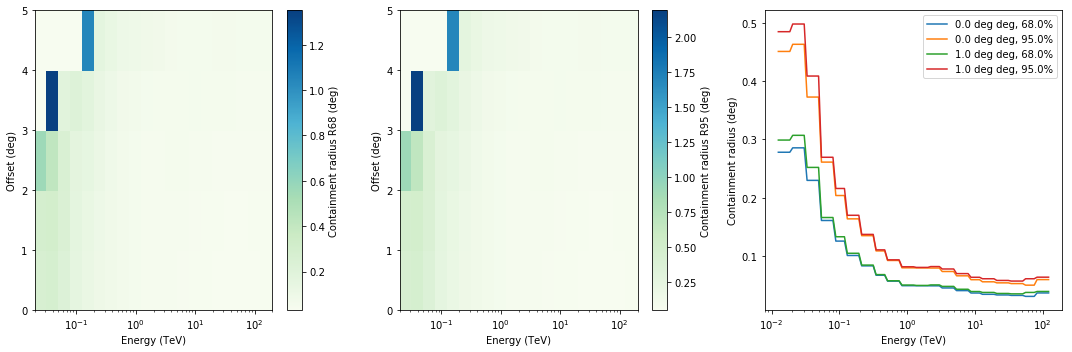

In [14]:
obs.psf.peek()

## Define inputs

Select the target position and define an ON region for the spectral analysis

In [15]:
target_position = SkyCoord(0, 0, unit='deg', frame='galactic')
on_radius = 0.2 * u.deg
on_region = CircleSkyRegion(center=target_position, radius=on_radius)

In [16]:
# Define reference image centered on the target
xref = target_position.galactic.l.value
yref = target_position.galactic.b.value
# size = 10 * u.deg
# binsz = 0.02 # degree per pixel
# npix = int((size / binsz).value)

ref_image = SkyImage.empty(
    nxpix=800, nypix=600, binsz=0.02,
    xref=xref, yref=yref,
    proj='TAN', coordsys='GAL',
)
print(ref_image)

Name: None
Data shape: (600, 800)
Data type: float64
Data unit: 
Data mean: 0.000e+00
WCS type: ['GLON-TAN', 'GLAT-TAN']



(<matplotlib.figure.Figure at 0x7fac1621ada0>,
 None)

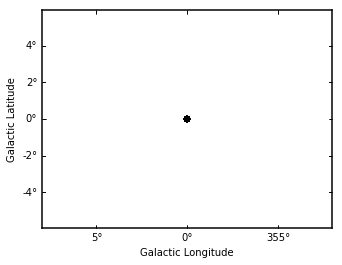

In [17]:
exclusion_mask = ref_image.region_mask(on_region)
exclusion_mask.data = 1 - exclusion_mask.data
exclusion_mask.plot()

## Make maps

Standard analysis products: Counts and Significance images

In [18]:
emin = 100 * u.GeV
emax = 100 * u.TeV

bkg_estimator = RingBackgroundEstimator(r_in=0.5 * u.deg, width=0.2 * u.deg)
image_estimator = IACTBasicImageEstimator(
    reference=ref_image,
    emin=emin, emax=emax,
    background_estimator=bkg_estimator,
    exclusion_mask=exclusion_mask,
)

images = image_estimator.run(observation_list)
images.names

/home/hfm/adonath/Software/Repositories/gammapy/gammapy/cube/core.py:85: RuntimeWarning: divide by zero encountered in log
  log_data = np.log(self.data.value)
/home/hfm/adonath/Software/Applications/anaconda3.5/lib/python3.5/site-packages/scipy/interpolate/interpolate.py:2382: RuntimeWarning: invalid value encountered in multiply
  values += np.asarray(self.values[edge_indices]) * weight[vslice]
/home/hfm/adonath/Software/Repositories/gammapy/gammapy/background/ring.py:322: RuntimeWarning: invalid value encountered in true_divide
  result['alpha'] = SkyImage(data=exposure_on.data / result['exposure_off'].data, wcs=wcs)
/home/hfm/adonath/Software/Repositories/gammapy/gammapy/image/models/gauss.py:254: RuntimeWarning: invalid value encountered in true_divide
  self.norms /= self.integral


['counts', 'exposure', 'background', 'excess', 'flux', 'psf']

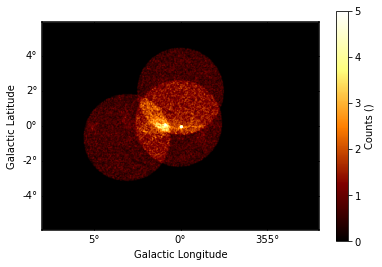

In [19]:
images['counts'].smooth(radius=3).show(add_cbar=True, vmax=5)

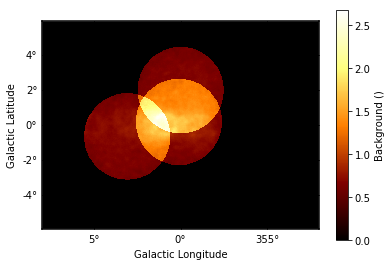

In [20]:
images['background'].show(add_cbar=True)

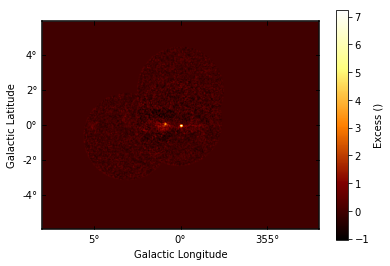

In [21]:
images['excess'].smooth(radius=3).show(add_cbar=True)

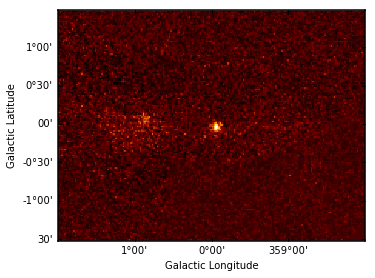

In [22]:
images['excess'].cutout(
    position=SkyCoord(0, 0, unit='deg', frame='galactic'),
    size=(3*u.deg, 4*u.deg),
).smooth(radius=1).show()

/home/hfm/adonath/Software/Repositories/gammapy/gammapy/stats/poisson.py:254: RuntimeWarning: divide by zero encountered in true_divide
  term_b = sqrt(n_on * log(n_on / mu_bkg) - n_on + mu_bkg)


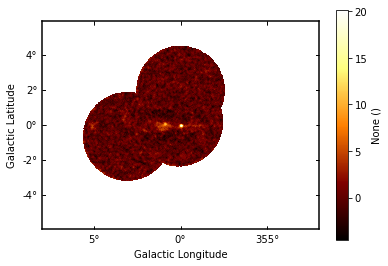

In [23]:
# Significance image
# Just for fun, let's compute it by hand ...
from astropy.convolution import Tophat2DKernel
kernel = Tophat2DKernel(4)
kernel.normalize('peak')

counts_conv = images['counts'].convolve(kernel.array)
background_conv = images['background'].convolve(kernel.array)

from gammapy.stats import significance
significance_image = SkyImage.empty_like(ref_image)
significance_image.data = significance(counts_conv.data, background_conv.data)
significance_image.show(add_cbar=True)

## Source Detection

Use the class [TSImageEstimator](http://docs.gammapy.org/en/latest/api/gammapy.detect.compute_ts_image.html#gammapy.detect.TSImageEstimator.html) and [photutils.find_peaks](http://photutils.readthedocs.io/en/stable/api/photutils.find_peaks.html) to detect point-like sources on the images:

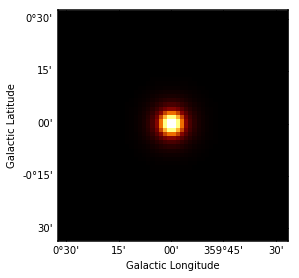

In [24]:
# cut out smaller piece of the PSF image to save computing time
# for covenience we're "misusing" the SkyImage class represent the PSF on the sky.
kernel = images['psf'].cutout(target_position, size= 1.1 * u.deg)
kernel.show()

In [25]:
ts_image_estimator = TSImageEstimator()

images_ts = ts_image_estimator.run(images, kernel.data)
print(images_ts.names)

['ts', 'sqrt_ts', 'flux', 'flux_err', 'niter']


In [26]:
# find pointlike sources with sqrt(TS) > 5
sources = find_peaks(data=images_ts['sqrt_ts'].data, threshold=5, wcs=images_ts['sqrt_ts'].wcs)
sources


/home/hfm/adonath/Software/Applications/anaconda3.5/lib/python3.5/site-packages/photutils/detection/core.py:241: RuntimeWarning: invalid value encountered in greater
  peak_goodmask = np.logical_and(peak_goodmask, (data > threshold))


x_peak,y_peak,icrs_ra_peak,icrs_dec_peak,peak_value
,,deg,deg,
int64,int64,float64,float64,float64
348,286,267.275264063,-28.1949994163,6.36931808646
145,292,269.453154512,-24.6469180992,5.79333009546
337,293,267.267586844,-27.9344019759,6.59342068605
342,295,267.170472293,-27.9994641575,6.84246351914
369,297,266.814955406,-28.4409687302,6.62235046705
403,297,266.412084142,-29.0219766936,22.3011633334
356,301,266.890126465,-28.1771575881,13.5043569049


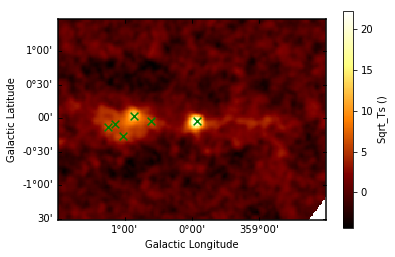

In [27]:
# plot sources on top of significance sky image
_, ax, _ = images_ts['sqrt_ts'].cutout(
    position=SkyCoord(0, 0, unit='deg', frame='galactic'),
    size=(3*u.deg, 4*u.deg)
).plot(add_cbar=True)

ax.scatter(sources['icrs_ra_peak'], sources['icrs_dec_peak'], transform=ax.get_transform('icrs'),
           color='g', marker='x', s=60)



# Spectrum

Standard analysis products: Spectrum and flux points

In [28]:
bkg_method = dict(
    method='reflected',
    exclusion=exclusion_mask,
)

extract = SpectrumExtraction(
    target=on_region,
    obs=observation_list,
    background=bkg_method,
)
extract.run()

TypeError: __init__() got an unexpected keyword argument 'target'

In [ ]:
extract.refl.plot(idx=[1, 2])

In [ ]:
model = models.PowerLaw(
    index = 2 * u.Unit(''),
    amplitude = 1e-11 * u.Unit('cm-2 s-1 TeV-1'),
    reference = 1 * u.TeV,
)

fit = SpectrumFit(extract.observations, model)
fit.fit()
fit.est_errors()
print(fit.result[0])

In [ ]:
# Flux points are computed on stacked observation
stacked_obs = extract.observations.stack()
print(stacked_obs)

ebounds = EnergyBounds.equal_log_spacing(1, 40, 4, unit = u.TeV)

seg = SpectrumEnergyGroupMaker(obs=stacked_obs)
seg.compute_range_safe()
seg.compute_groups_fixed(ebounds=ebounds)

fpe = FluxPointEstimator(
    obs=stacked_obs,
    groups=seg.groups,
    model=fit.result[0].model,
)
fpe.compute_points()
fpe.flux_points.table

In [ ]:
total_result = SpectrumResult(
    model=fit.result[0].model,
    points=fpe.flux_points,
)

total_result.plot(energy_range = [1, 40] * u.TeV,
                 fig_kwargs=dict(figsize=(8,8)),
                 point_kwargs=dict(color='green'))

## What next?

* Give us a few weeks to fix things up with the 1DC data and Gammapy.
* Go explore CTA 1DC!